<a href="https://colab.research.google.com/github/officialjwise/crop_disease_detection_system/blob/main/Disease_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle


In [2]:
!mkdir -p /content/Plant_Disease_Detection/kaggle


In [3]:
from google.colab import files
files.upload()  # Upload kaggle.json here

# Move kaggle.json to the new directory in Plant_Disease_Detection
!mv kaggle.json /content/Plant_Disease_Detection/kaggle/
!chmod 600 /content/Plant_Disease_Detection/kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [4]:
!kaggle datasets download -d tushar5harma/plant-village-dataset-updated -p /content/Plant_Disease_Detection/datasets


Dataset URL: https://www.kaggle.com/datasets/tushar5harma/plant-village-dataset-updated
License(s): CC0-1.0
100% 1.00G/1.00G [00:51<00:00, 21.8MB/s]
100% 1.00G/1.00G [00:51<00:00, 20.8MB/s]


In [5]:
import zipfile
with zipfile.ZipFile('/content/Plant_Disease_Detection/datasets/plant-village-dataset-updated.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/Plant_Disease_Detection/datasets')

In [6]:
# Cell 1: Setup and GPU Check
!nvidia-smi

Sun Oct 27 15:25:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:

!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 877.6/877.6 kB 42.9 MB/s eta 0:00:00


In [8]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import seaborn as sns
from PIL import Image
import yaml
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [9]:
# Define base directories
BASE_DIR = Path('/content/Plant_Disease_Detection')
DATASET_DIR = BASE_DIR / 'datasets'  # Main dataset directory
DATA_DIR = BASE_DIR / 'data'

print("Directory Structure:")
print(f"Base Directory: {BASE_DIR}")
print(f"Dataset Directory: {DATASET_DIR}")

Directory Structure:
Base Directory: /content/Plant_Disease_Detection
Dataset Directory: /content/Plant_Disease_Detection/datasets


In [10]:
# Cell 3: Dataset Structure Analysis Function
def analyze_dataset():
    print("Starting dataset analysis...")
    dataset_info = {
        'train': {},
        'val': {},
        'test': {}
    }

    # Debug: Print all items in DATASET_DIR
    print("\nContents of DATASET_DIR:")
    try:
        for item in DATASET_DIR.iterdir():
            print(f"Found: {item}")
    except Exception as e:
        print(f"Error accessing DATASET_DIR: {e}")

    # Count total dirs and files
    try:
        total_dirs = len([x for x in DATASET_DIR.iterdir() if x.is_dir()])
        print(f"\nTotal directories found: {total_dirs}")
    except Exception as e:
        print(f"Error counting directories: {e}")

    # Iterate through plant classes with more detailed debugging
    for plant_dir in sorted(DATASET_DIR.iterdir()):
        print(f"\nChecking path: {plant_dir}")

        if not plant_dir.is_dir():
            print(f"Skipping {plant_dir} as it's not a directory")
            continue

        plant_name = plant_dir.name
        print(f"\nProcessing {plant_name}:")

        # Iterate through splits (Train, Val, Test)
        for split in ['Train', 'Val', 'Test']:
            split_path = plant_dir / split
            print(f"  Checking split path: {split_path}")

            if split_path.exists():
                print(f"  Found {split} directory")
                # Iterate through disease classes
                for disease_dir in sorted(split_path.iterdir()):
                    if not disease_dir.is_dir():
                        continue

                    disease_name = disease_dir.name
                    image_count = len(list(disease_dir.glob('*.JPG')))

                    # Store image count for each disease class in the respective split
                    if plant_name not in dataset_info[split.lower()]:
                        dataset_info[split.lower()][plant_name] = {}
                    dataset_info[split.lower()][plant_name][disease_name] = image_count

                    print(f"    {split} - {disease_name}: {image_count} images")
            else:
                print(f"  {split} directory not found")

    return dataset_info

# Run the analysis
print("\nAnalyzing dataset structure...")
try:
    dataset_info = analyze_dataset()
    print("\nAnalysis completed successfully")

    # Print summary of findings
    print("\nDataset Summary:")
    for split in dataset_info:
        print(f"\n{split.upper()} set:")
        for plant in dataset_info[split]:
            print(f"  {plant}:")
            for disease, count in dataset_info[split][plant].items():
                print(f"    {disease}: {count} images")
except Exception as e:
    print(f"Error during analysis: {e}")


Analyzing dataset structure...
Starting dataset analysis...

Contents of DATASET_DIR:
Found: /content/Plant_Disease_Detection/datasets/Bell Pepper
Found: /content/Plant_Disease_Detection/datasets/plant-village-dataset-updated.zip
Found: /content/Plant_Disease_Detection/datasets/Cherry
Found: /content/Plant_Disease_Detection/datasets/Grape
Found: /content/Plant_Disease_Detection/datasets/Apple
Found: /content/Plant_Disease_Detection/datasets/Corn (Maize)
Found: /content/Plant_Disease_Detection/datasets/Potato
Found: /content/Plant_Disease_Detection/datasets/Peach
Found: /content/Plant_Disease_Detection/datasets/Strawberry
Found: /content/Plant_Disease_Detection/datasets/Tomato

Total directories found: 9

Checking path: /content/Plant_Disease_Detection/datasets/Apple

Processing Apple:
  Checking split path: /content/Plant_Disease_Detection/datasets/Apple/Train
  Found Train directory
    Train - Apple Scab: 2016 images
    Train - Black Rot: 1987 images
    Train - Cedar Apple Rust: 1


Training Data Analysis:
Total number of plant types: 9
Total number of disease classes: 16
Total number of images: 51262


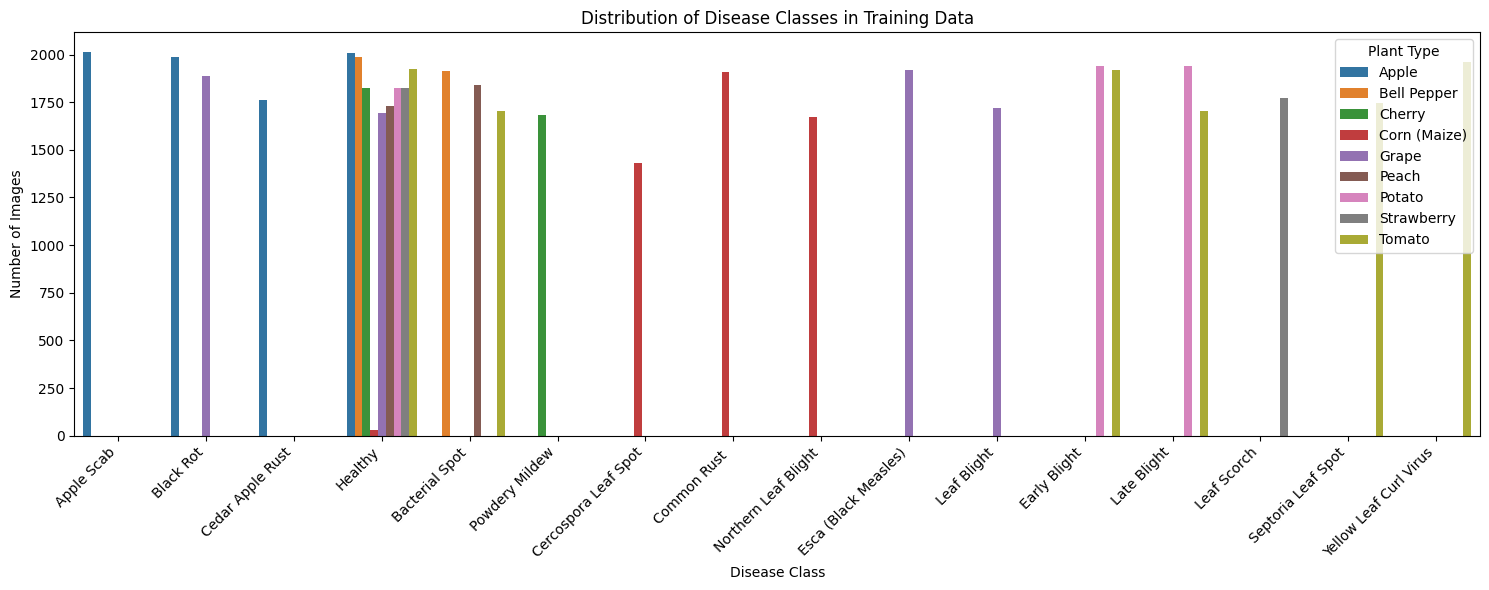


Detailed Distribution:

Apple:
  Apple Scab: 2016 images
  Black Rot: 1987 images
  Cedar Apple Rust: 1760 images
  Healthy: 2008 images

Bell Pepper:
  Bacterial Spot: 1913 images
  Healthy: 1987 images

Cherry:
  Healthy: 1826 images
  Powdery Mildew: 1683 images

Corn (Maize):
  Cercospora Leaf Spot: 1429 images
  Common Rust : 1907 images
  Healthy: 28 images
  Northern Leaf Blight: 1673 images

Grape:
  Black Rot: 1888 images
  Esca (Black Measles): 1920 images
  Healthy: 1692 images
  Leaf Blight: 1722 images

Peach:
  Bacterial Spot: 1838 images
  Healthy: 1728 images

Potato:
  Early Blight: 1939 images
  Healthy: 1824 images
  Late Blight: 1939 images

Strawberry:
  Healthy: 1824 images
  Leaf Scorch: 1773 images

Tomato:
  Bacterial Spot: 1702 images
  Early Blight: 1920 images
  Healthy: 1925 images
  Late Blight: 1705 images
  Septoria Leaf Spot: 1745 images
  Yellow Leaf Curl Virus: 1961 images


In [11]:
# Cell 4: Analyze Training Data
def analyze_training_data():
    """Analyze and visualize the training data distribution"""
    print("\nTraining Data Analysis:")

    # Initialize lists to store data
    all_diseases = []
    image_counts = []

    # Iterate through the dataset structure to collect training data info
    train_data = []
    for plant_dir in sorted(DATASET_DIR.iterdir()):
        if not plant_dir.is_dir():
            continue

        plant_name = plant_dir.name
        train_path = plant_dir / 'Train'

        if train_path.exists():
            for disease_dir in sorted(train_path.iterdir()):
                if not disease_dir.is_dir():
                    continue

                disease_name = disease_dir.name
                image_count = len(list(disease_dir.glob('*.JPG')))

                train_data.append({
                    'plant': plant_name,
                    'disease': disease_name,
                    'count': image_count
                })

    # Convert to DataFrame for easier analysis
    train_df = pd.DataFrame(train_data)

    print(f"Total number of plant types: {len(train_df['plant'].unique())}")
    print(f"Total number of disease classes: {len(train_df['disease'].unique())}")
    print(f"Total number of images: {train_df['count'].sum()}")

    # Create disease distribution plot
    plt.figure(figsize=(15, 6))
    sns.barplot(data=train_df, x='disease', y='count', hue='plant')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Disease Classes in Training Data')
    plt.xlabel('Disease Class')
    plt.ylabel('Number of Images')
    plt.legend(title='Plant Type')
    plt.tight_layout()
    plt.show()

    # Display detailed distribution
    print("\nDetailed Distribution:")
    for plant in sorted(train_df['plant'].unique()):
        print(f"\n{plant}:")
        plant_data = train_df[train_df['plant'] == plant]
        for _, row in plant_data.iterrows():
            print(f"  {row['disease']}: {row['count']} images")

    return train_df

# Run the analysis
train_df = analyze_training_data()

Creating training annotations file...

Created Train.csv with 51262 annotations

Annotation Statistics:
Total number of images: 51262
Total number of classes: 29


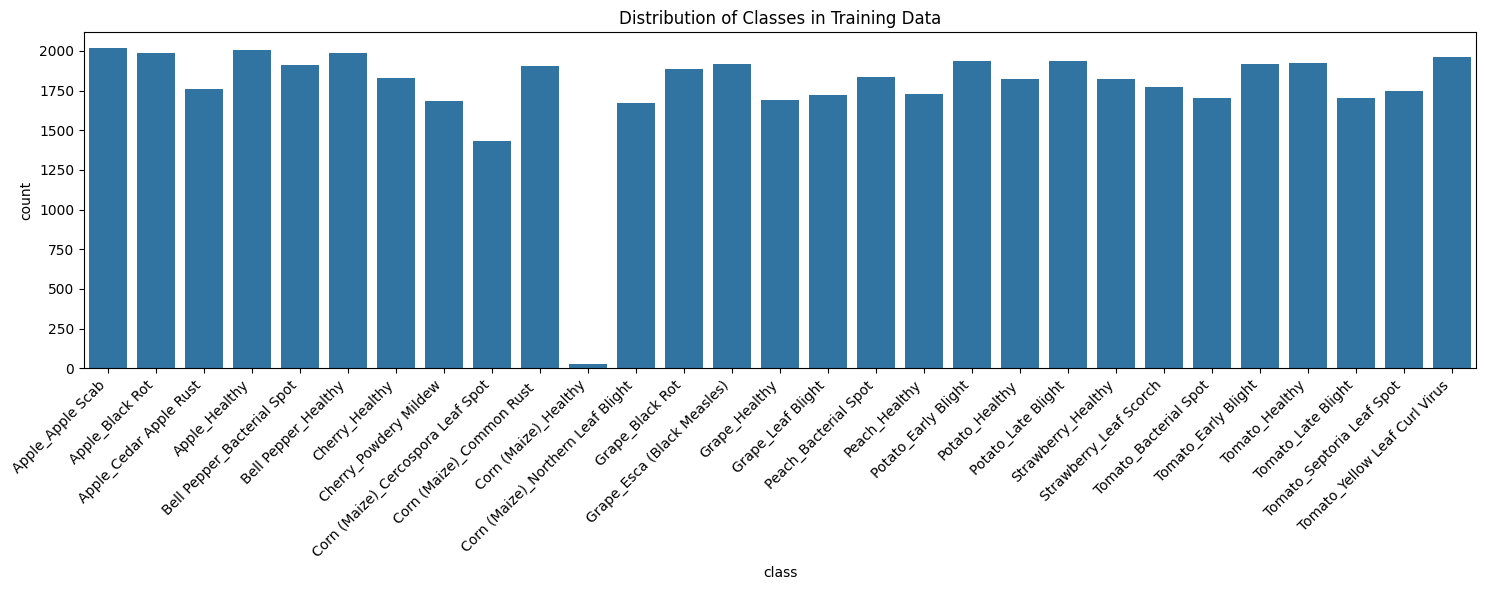

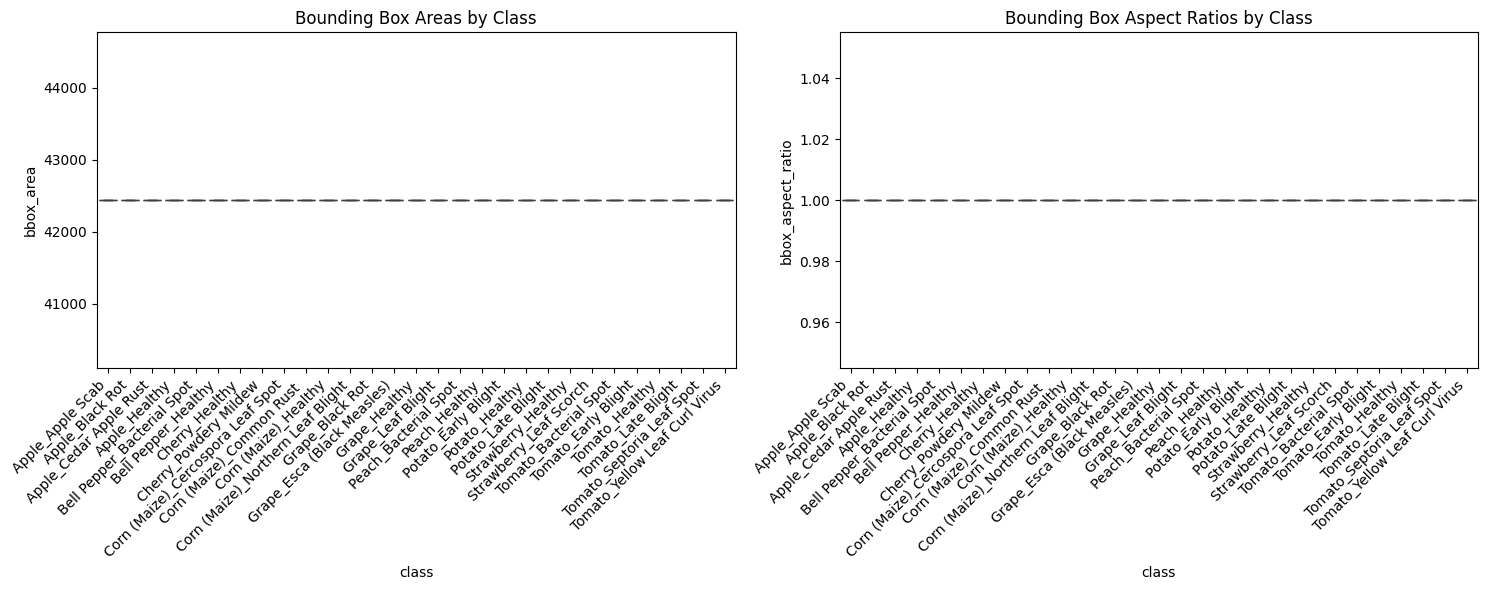

In [12]:
# Cell 5: Create and Analyze Training Annotations
def create_training_annotations():
    """Create Train.csv file with bounding box annotations"""
    print("Creating training annotations file...")

    annotations = []

    # Iterate through dataset to create annotations
    for plant_dir in sorted(DATASET_DIR.iterdir()):
        if not plant_dir.is_dir():
            continue

        plant_name = plant_dir.name
        train_path = plant_dir / 'Train'

        if train_path.exists():
            for disease_dir in sorted(train_path.iterdir()):
                if not disease_dir.is_dir():
                    continue

                disease_name = disease_dir.name

                # Process each image in the disease directory
                for img_path in disease_dir.glob('*.JPG'):
                    try:
                        # Read image to get dimensions
                        img = cv2.imread(str(img_path))
                        height, width = img.shape[:2]

                        # Create a bounding box that covers most of the image
                        # Using 80% of image size as a default
                        margin_x = int(width * 0.1)  # 10% margin on each side
                        margin_y = int(height * 0.1)  # 10% margin on each side

                        annotation = {
                            'Image_ID': img_path.name,
                            'class': f"{plant_name}_{disease_name}",
                            'confidence': 1.0,  # Ground truth confidence
                            'xmin': margin_x,
                            'ymin': margin_y,
                            'xmax': width - margin_x,
                            'ymax': height - margin_y
                        }
                        annotations.append(annotation)

                    except Exception as e:
                        print(f"Error processing {img_path}: {e}")

    # Create DataFrame and save to CSV
    train_df = pd.DataFrame(annotations)

    # Create data directory if it doesn't exist
    data_dir = BASE_DIR / 'data'
    data_dir.mkdir(parents=True, exist_ok=True)

    # Save to CSV
    csv_path = data_dir / 'Train.csv'
    train_df.to_csv(csv_path, index=False)
    print(f"\nCreated Train.csv with {len(train_df)} annotations")

    # Basic analysis
    print("\nAnnotation Statistics:")
    print(f"Total number of images: {len(train_df['Image_ID'].unique())}")
    print(f"Total number of classes: {len(train_df['class'].unique())}")

    # Visualize class distribution
    plt.figure(figsize=(15, 6))
    sns.countplot(data=train_df, x='class')
    plt.xticks(rotation=45, ha='right')
    plt.title('Distribution of Classes in Training Data')
    plt.tight_layout()
    plt.show()

    # Calculate and visualize bounding box statistics
    train_df['bbox_width'] = train_df['xmax'] - train_df['xmin']
    train_df['bbox_height'] = train_df['ymax'] - train_df['ymin']
    train_df['bbox_area'] = train_df['bbox_width'] * train_df['bbox_height']

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train_df, x='class', y='bbox_area')
    plt.xticks(rotation=45, ha='right')
    plt.title('Bounding Box Areas by Class')

    train_df['bbox_aspect_ratio'] = train_df['bbox_width'] / train_df['bbox_height']
    plt.subplot(1, 2, 2)
    sns.boxplot(data=train_df, x='class', y='bbox_aspect_ratio')
    plt.xticks(rotation=45, ha='right')
    plt.title('Bounding Box Aspect Ratios by Class')
    plt.tight_layout()
    plt.show()

    return train_df

# Run the annotation creation and analysis
train_df = create_training_annotations()

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.20 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Initializing disease detection system...
Using device: cuda

Processing test images...
Loading models and initializing parameters...
Loading feature extractor...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


Loading disease classifier...


100%|██████████| 44.7M/44.7M [00:00<00:00, 141MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading segmentation model...


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 159MB/s]


Initialization complete!

Processing: /content/Plant_Disease_Detection/datasets/Bell Pepper/Train/Healthy/5ea016e4-284f-45ac-b9da-60d4ac5141e4___JR_HL 7987.JPG
Plant: Bell Pepper, Disease: Healthy


<ipython-input-13-dab8c2a95eac>:138: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


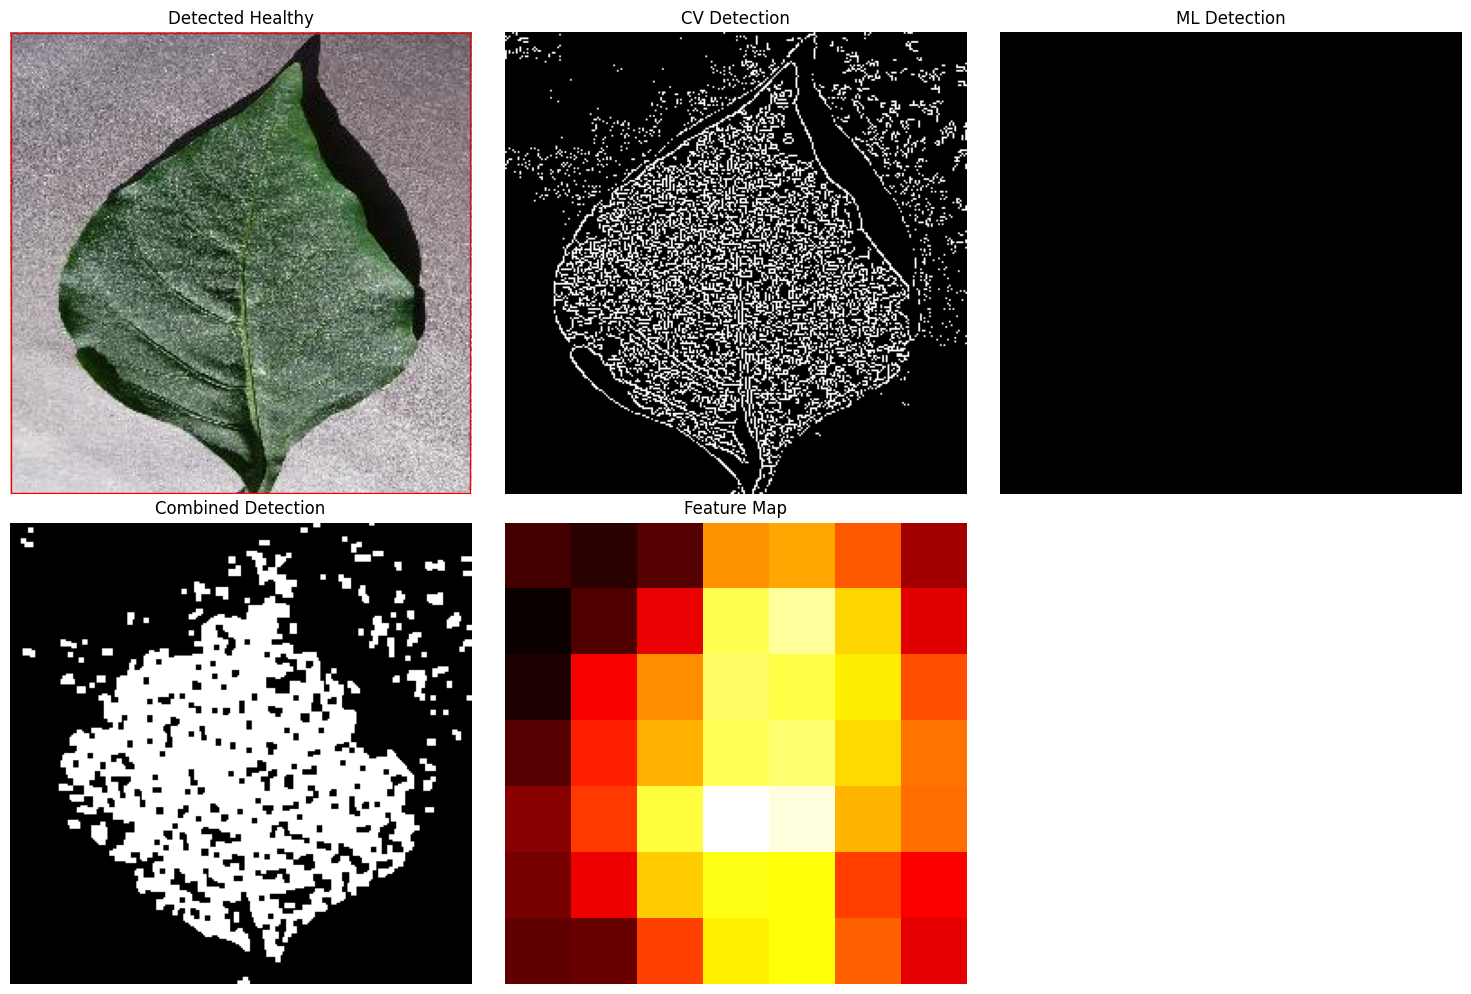


Processing: /content/Plant_Disease_Detection/datasets/Bell Pepper/Train/Bacterial Spot/47773ddb-e400-4a5d-87ec-ce711044c31e___NREC_B.Spot 9235_flipTB.JPG
Plant: Bell Pepper, Disease: Bacterial Spot


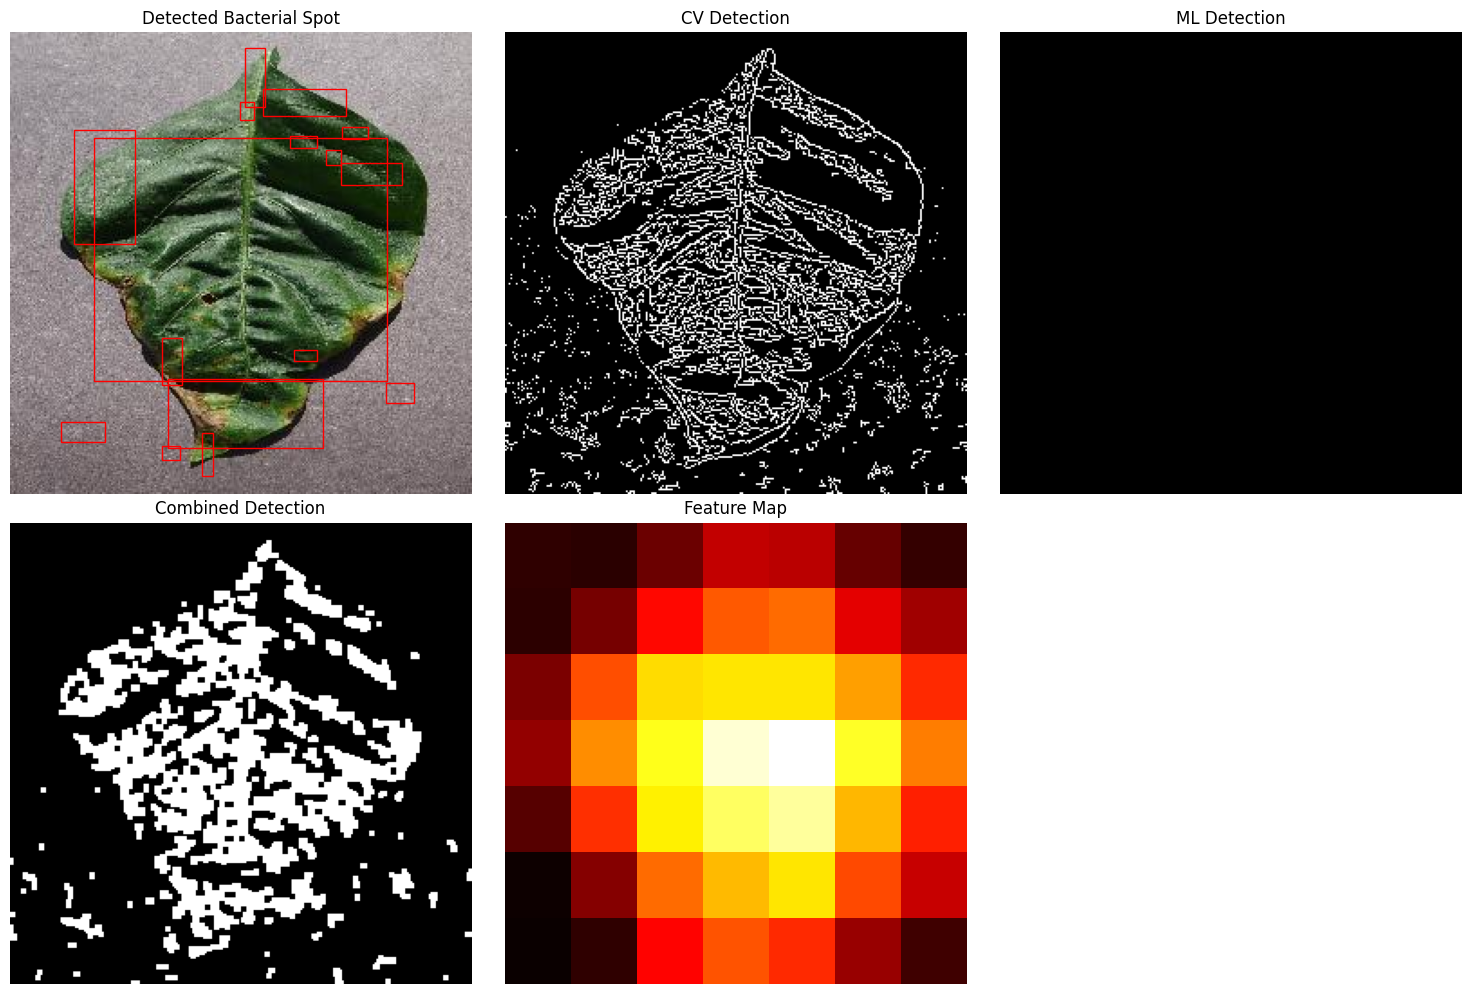


Processing: /content/Plant_Disease_Detection/datasets/Cherry/Train/Healthy/e68b0372-4f11-4706-8473-9e99aec160ce___JR_HL 9434_flipTB.JPG
Plant: Cherry, Disease: Healthy


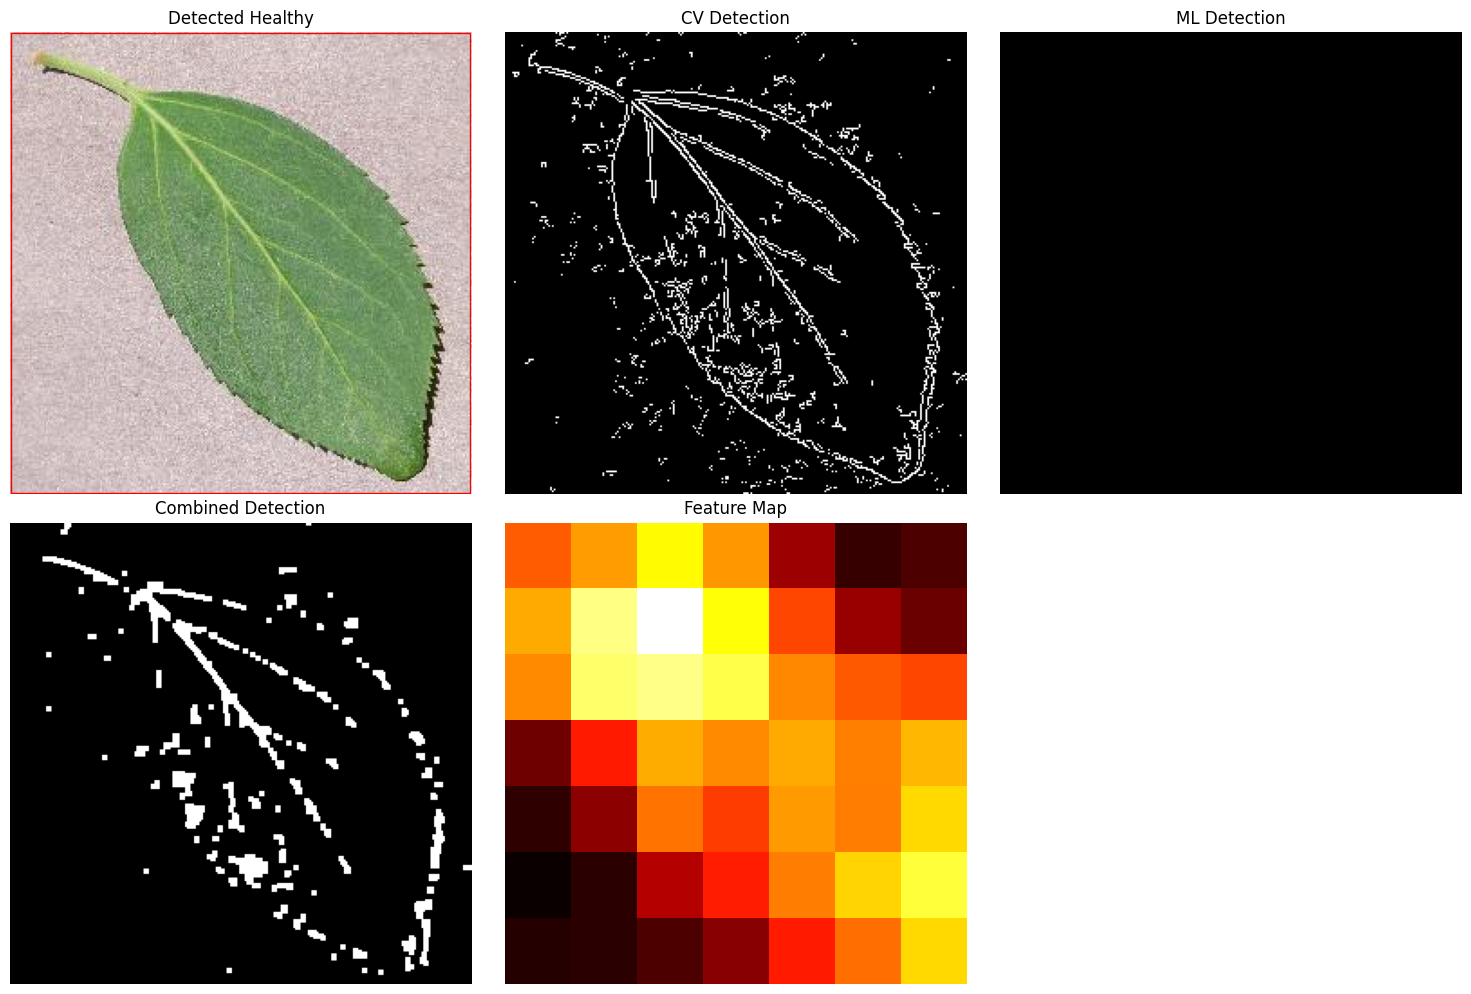


Processing: /content/Plant_Disease_Detection/datasets/Cherry/Train/Powdery Mildew/20b3dbf2-058a-4b8c-8c1d-202b60da82f6___FREC_Pwd.M 0406.JPG
Plant: Cherry, Disease: Powdery Mildew


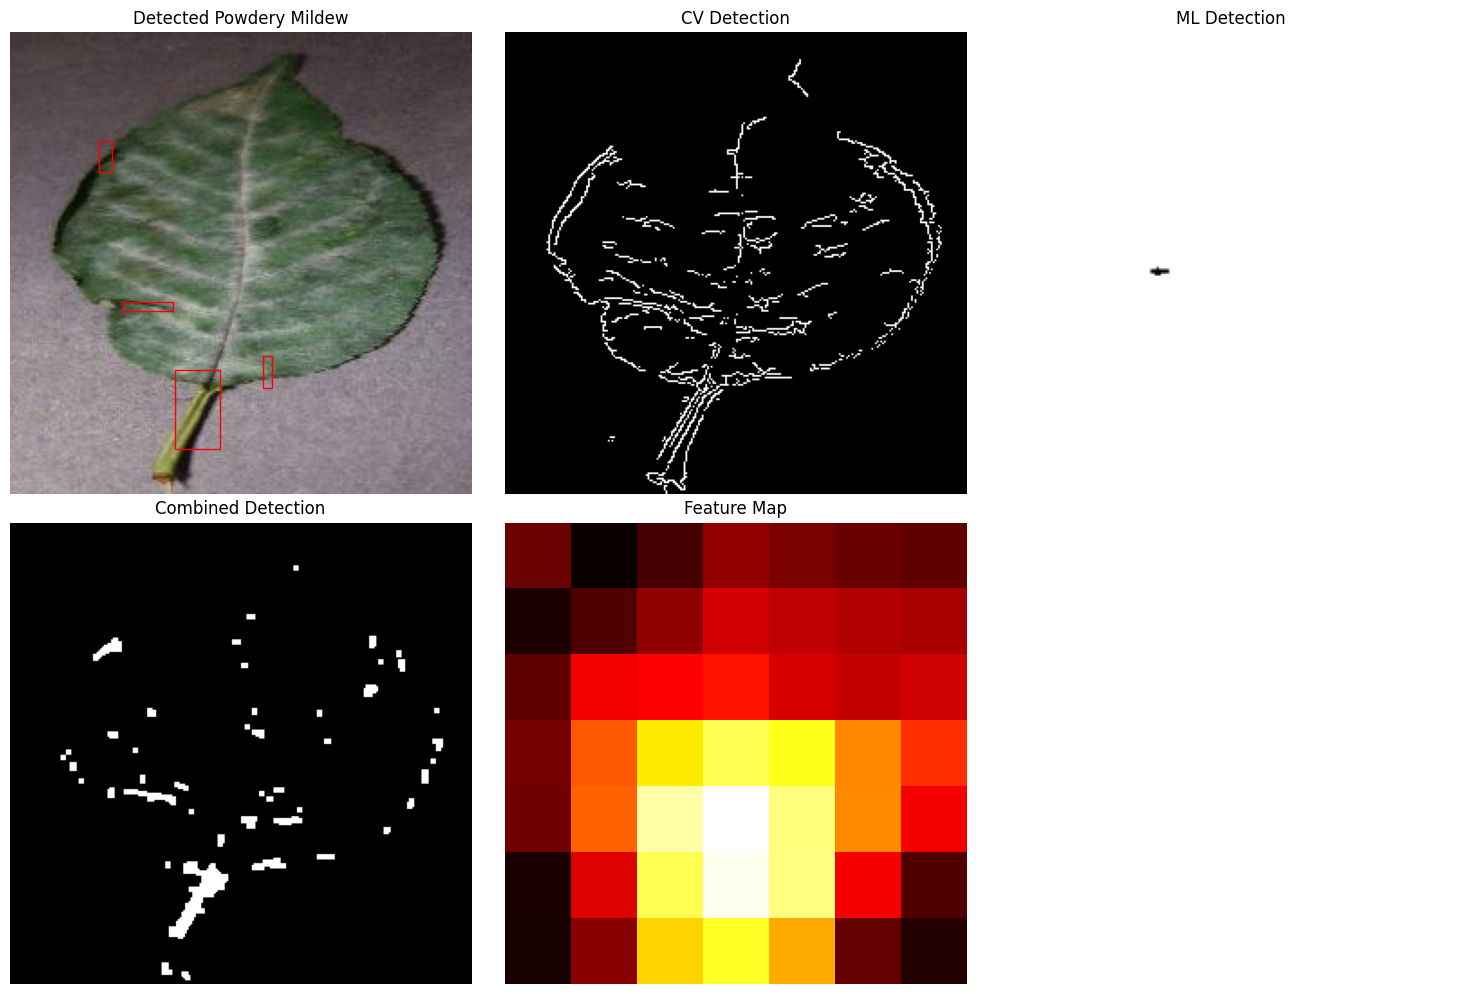


Processing: /content/Plant_Disease_Detection/datasets/Grape/Train/Healthy/c197dfe9-44d6-4a7e-bb5a-75e2bf05380b___Mt.N.V_HL 6100_new30degFlipLR.JPG
Plant: Grape, Disease: Healthy


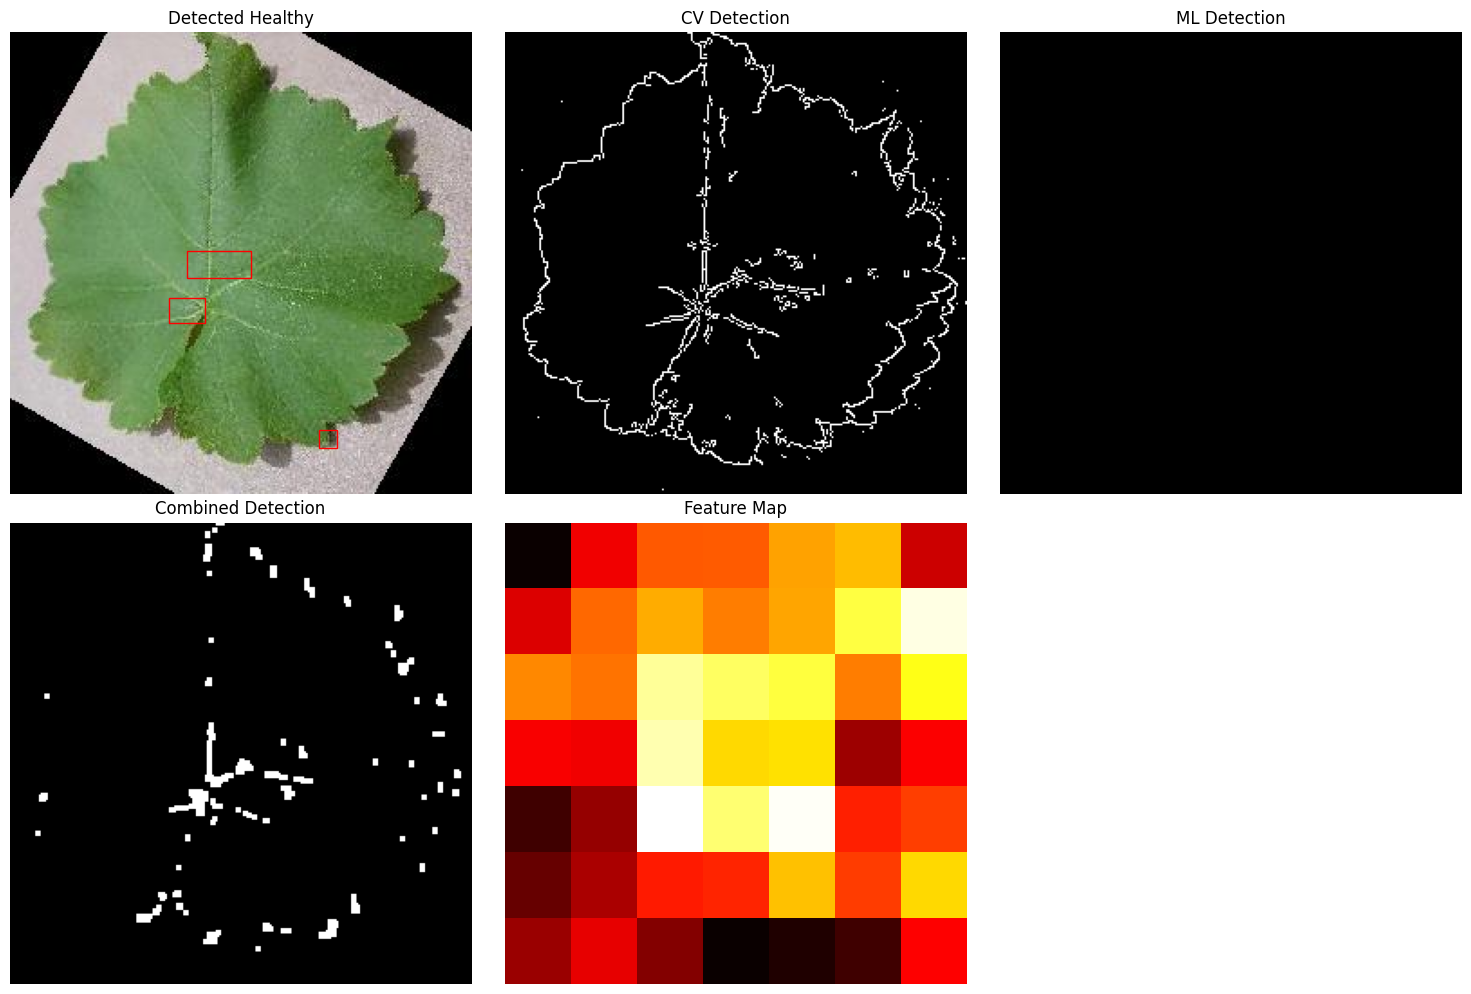


Processing: /content/Plant_Disease_Detection/datasets/Grape/Train/Leaf Blight/12ac35fb-6b5b-4b37-9031-bbca2928ffce___FAM_L.Blight 5000.JPG
Plant: Grape, Disease: Leaf Blight


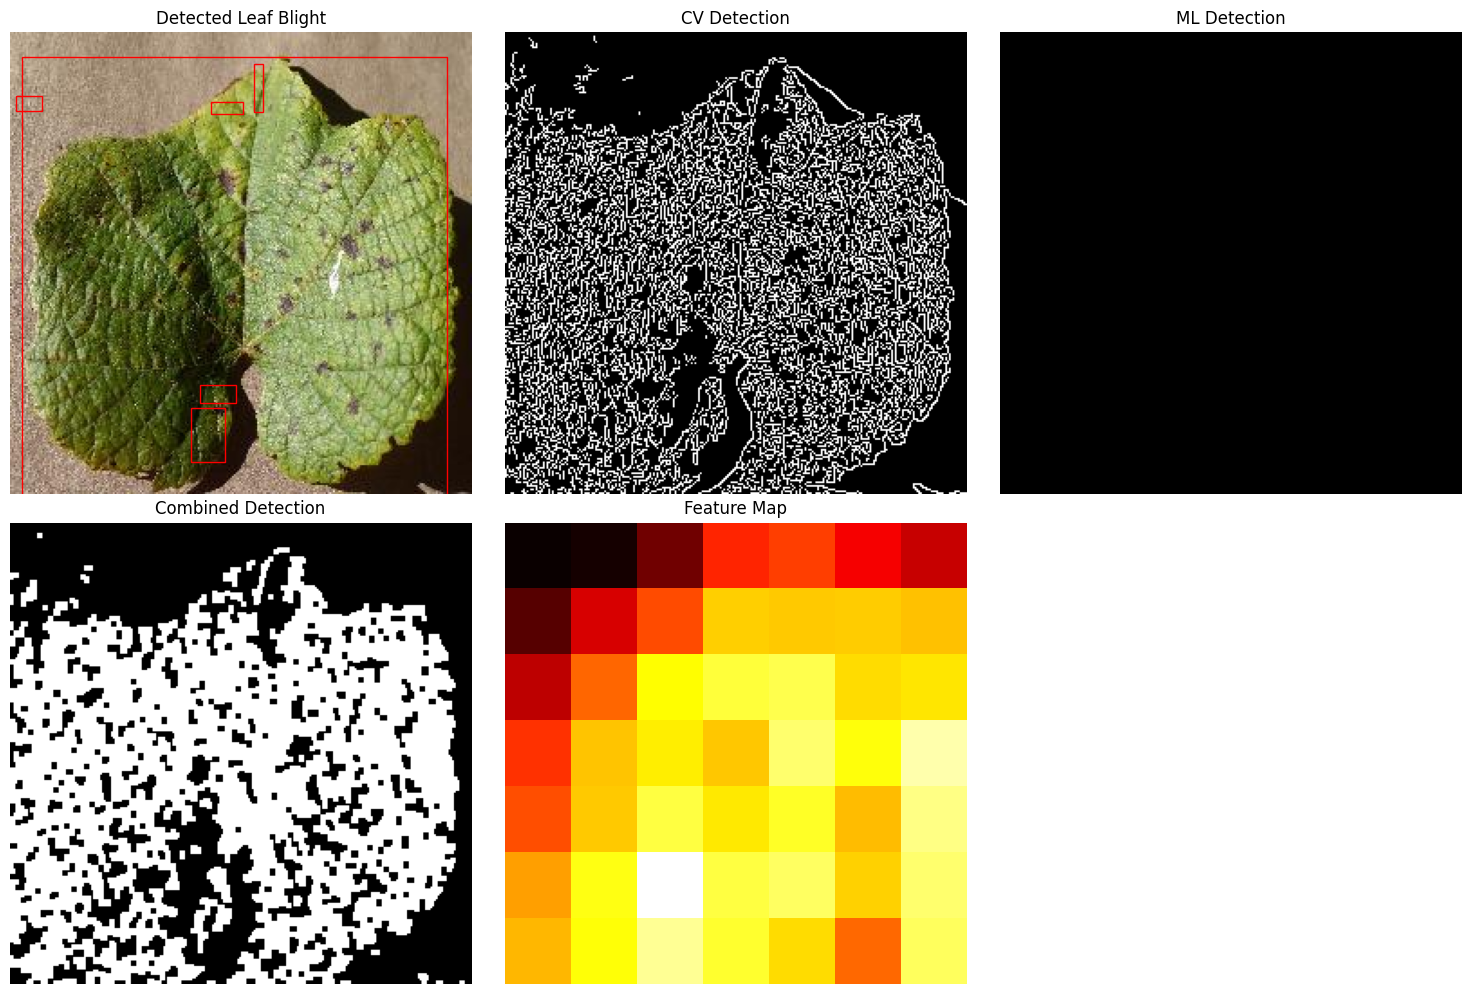

Completed processing requested number of images.


In [13]:
# Cell 6: Advanced Disease Detection and Visualization
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import feature, filters, measure
from scipy import ndimage
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from PIL import Image
import albumentations as A
from tqdm.notebook import tqdm

print("Initializing disease detection system...")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

def to_device(model):
    return model.to(device)

class DiseaseDetector:
    def __init__(self):
        print("Loading models and initializing parameters...")
        # First initialize parameters
        self._initialize_parameters()
        # Then load models and move to device
        self.feature_extractor = to_device(self._load_feature_extractor())
        self.disease_classifier = to_device(self._load_disease_classifier())
        self.segmentation_model = to_device(self._load_segmentation_model())
        # Setup transforms
        self.transform = A.Compose([
            A.Resize(224, 224),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        print("Initialization complete!")

    def _initialize_parameters(self):
        self.disease_params = {
            disease: {
                'color_ranges': [((0, 20, 20), (180, 255, 255))],
                'texture_threshold': 0.4,
                'edge_threshold': 0.35,
                'confidence_threshold': 0.7
            } for disease in ['Early_Blight', 'Late_Blight', 'Bacterial_Spot', 'Healthy']
        }

    def detect_disease_regions(self, image, disease_type):
        # CV Detection
        cv_mask = self._cv_detection(image, disease_type)
        # ML Detection
        ml_mask, features = self._ml_detection(image)

        # Enhance mask using morphological operations
        kernel = np.ones((3,3), np.uint8)
        combined_mask = cv2.addWeighted(cv_mask, 0.4, ml_mask, 0.6, 0)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
        combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)

        # Apply additional processing for better disease spot detection
        if disease_type != 'Healthy':
            _, combined_mask = cv2.threshold(combined_mask, 127, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        return combined_mask, {
            'cv_mask': cv_mask,
            'ml_mask': ml_mask,
            'features': features,
            'combined_mask': combined_mask
        }

    def _cv_detection(self, image, disease_type):
        params = self.disease_params[disease_type if disease_type in self.disease_params else 'Healthy']

        # Color detection
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
        for lower, upper in params['color_ranges']:
            mask |= cv2.inRange(hsv, np.array(lower), np.array(upper))

        # Edge detection
        edges = cv2.Canny(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 100, 200)

        return cv2.bitwise_and(mask, edges)

    def _ml_detection(self, image):
        with torch.no_grad():
            transformed = self.transform(image=image)['image']
            input_tensor = torch.tensor(transformed).permute(2,0,1).unsqueeze(0).float().to(device)

            # Extract features
            features = self.feature_extractor(input_tensor)

            # Create mask using segmentation model
            mask_pred = self.segmentation_model(input_tensor)['out']
            mask = (torch.sigmoid(mask_pred) > 0.5).float()
            mask = mask.squeeze().cpu().numpy()
            mask = (cv2.resize(mask, (image.shape[1], image.shape[0])) * 255).astype(np.uint8)

            return mask, features

    def _load_feature_extractor(self):
        print("Loading feature extractor...")
        model = models.resnet50(pretrained=True)
        model = nn.Sequential(*list(model.children())[:-2])
        model.eval()
        return model

    def _load_disease_classifier(self):
        print("Loading disease classifier...")
        model = models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, len(self.disease_params))
        model.eval()
        return model

    def _load_segmentation_model(self):
        print("Loading segmentation model...")
        model = models.segmentation.deeplabv3_resnet50(pretrained=True)
        model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
        model.eval()
        return model

    def get_bounding_boxes(self, mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        height, width = mask.shape
        boxes = []

        for contour in contours:
            area = cv2.contourArea(contour)
            if area < 50:  # Reduced minimum area threshold
                continue

            # Use minAreaRect to get better fitting boxes
            rect = cv2.minAreaRect(contour)
            box = cv2.boxPoints(rect)
            box = np.int0(box)

            # Calculate center and dimensions
            x_center = rect[0][0] / width
            y_center = rect[0][1] / height
            box_width = rect[1][0] / width
            box_height = rect[1][1] / height

            # Calculate confidence based on contour properties
            contour_area = cv2.contourArea(contour)
            hull_area = cv2.contourArea(cv2.convexHull(contour))
            if hull_area > 0:
                confidence = min(contour_area / hull_area, 1.0)
            else:
                confidence = 0.5

            boxes.append((x_center, y_center, box_width, box_height, confidence))

        return boxes

class ResultVisualizer:
    def __init__(self):
        self.cmap = plt.colormaps['viridis']

    def visualize_results(self, image, results, boxes, disease_type):
        plt.figure(figsize=(15, 10))

        # Original image with boxes
        plt.subplot(231)
        self._plot_image_with_boxes(image, boxes, disease_type)

        # CV mask
        plt.subplot(232)
        plt.imshow(results['cv_mask'], cmap='gray')
        plt.title('CV Detection')
        plt.axis('off')

        # ML mask
        plt.subplot(233)
        plt.imshow(results['ml_mask'], cmap='gray')
        plt.title('ML Detection')
        plt.axis('off')

        # Combined mask
        plt.subplot(234)
        plt.imshow(results['combined_mask'], cmap='gray')
        plt.title('Combined Detection')
        plt.axis('off')

        # Feature visualization
        plt.subplot(235)
        features = results['features'][0].mean(dim=0).cpu().numpy()
        plt.imshow(features, cmap='hot')
        plt.title('Feature Map')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def _plot_image_with_boxes(self, image, boxes, disease_type):
        plt.imshow(image)
        height, width = image.shape[:2]

        for box in boxes:
            x_center, y_center, box_width, box_height, confidence = box
            x = int((x_center - box_width/2) * width)
            y = int((y_center - box_height/2) * height)
            w = int(box_width * width)
            h = int(box_height * height)

            rect = plt.Rectangle((x, y), w, h, fill=False, color='red')
            plt.gca().add_patch(rect)

        plt.title(f'Detected {disease_type}')
        plt.axis('off')

def process_test_images(num_images=5):
    print("\nProcessing test images...")

    detector = DiseaseDetector()
    visualizer = ResultVisualizer()

    processed_count = 0
    processed_combinations = set()

    # Process images from different plant/disease combinations
    for plant_dir in DATASET_DIR.iterdir():
        if not plant_dir.is_dir():
            continue

        train_path = plant_dir / 'Train'
        if not train_path.exists():
            continue

        for disease_dir in train_path.iterdir():
            if not disease_dir.is_dir():
                continue

            # Skip if we've already processed this plant/disease combination
            combination = (plant_dir.name, disease_dir.name)
            if combination in processed_combinations:
                continue

            image_files = list(disease_dir.glob('*.JPG'))
            if not image_files:
                continue

            # Process one image from this combination
            try:
                img_path = image_files[0]
                print(f"\nProcessing: {img_path}")
                print(f"Plant: {plant_dir.name}, Disease: {disease_dir.name}")

                # Read and process image
                img = cv2.imread(str(img_path))
                if img is None:
                    continue

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                # Detect diseases
                mask, results = detector.detect_disease_regions(img, disease_dir.name)
                boxes = detector.get_bounding_boxes(mask)

                # Visualize results
                visualizer.visualize_results(img, results, boxes, disease_dir.name)

                processed_combinations.add(combination)
                processed_count += 1

                if processed_count >= num_images:
                    print("Completed processing requested number of images.")
                    return

            except Exception as e:
                print(f"Error processing image: {str(e)}")
                continue

    print(f"Processed {processed_count} images.")

# Main execution
if __name__ == "__main__":
    plt.close('all')
    process_test_images(6)  # Process 5 images

Running complete dataset analysis...

Analyzing image quality characteristics...


Processing plants: 0it [00:00, ?it/s]

<ipython-input-14-b118bbf329f4>:88: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


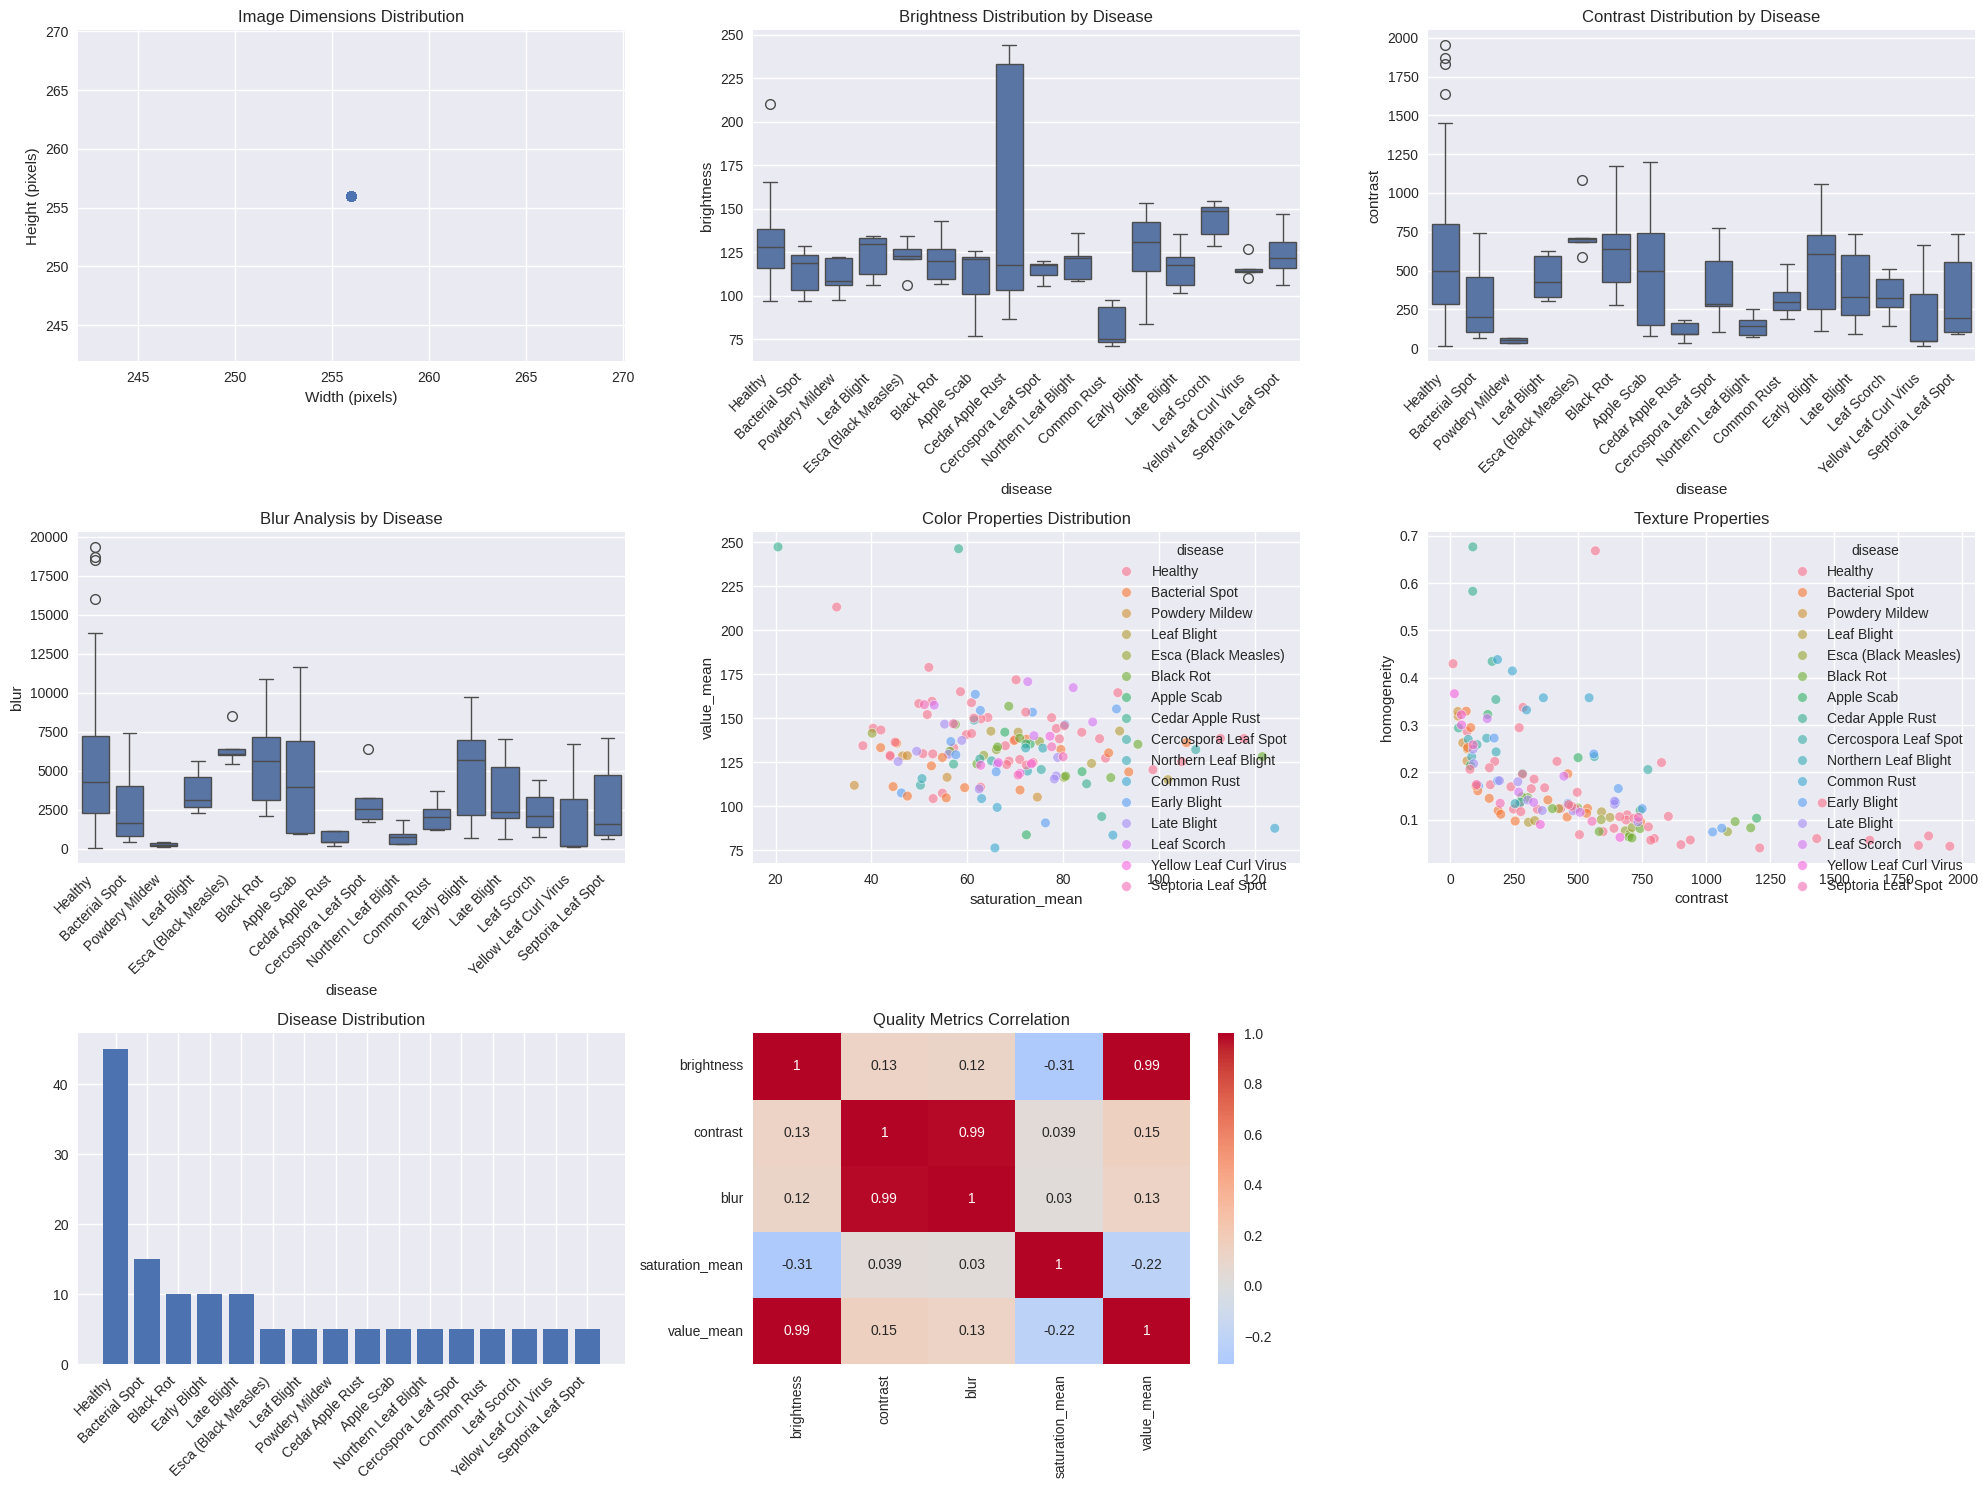

In [14]:
# Cell 7: Image Quality Analysis
def analyze_image_quality(sample_size=50):
    """Analyze image quality characteristics across dataset"""
    print("\nAnalyzing image quality characteristics...")

    image_stats = []

    for plant_dir in tqdm(DATASET_DIR.iterdir(), desc="Processing plants"):
        if not plant_dir.is_dir():
            continue

        train_path = plant_dir / 'Train'
        if not train_path.exists():
            continue

        for disease_dir in train_path.iterdir():
            if not disease_dir.is_dir():
                continue

            # Sample images from each disease directory
            image_files = list(disease_dir.glob('*.JPG'))
            n_samples = min(sample_size // len(list(DATASET_DIR.iterdir())), len(image_files))
            sampled_files = np.random.choice(image_files, n_samples, replace=False)

            for img_path in sampled_files:
                try:
                    # Read image
                    img = cv2.imread(str(img_path))
                    if img is None:
                        continue

                    # Convert to different color spaces
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                    # Calculate basic metrics
                    brightness = np.mean(gray)
                    contrast = np.std(gray)
                    blur = cv2.Laplacian(gray, cv2.CV_64F).var()

                    # Calculate color metrics
                    color_stats = {
                        'saturation_mean': np.mean(img_hsv[:,:,1]),
                        'saturation_std': np.std(img_hsv[:,:,1]),
                        'value_mean': np.mean(img_hsv[:,:,2]),
                        'value_std': np.std(img_hsv[:,:,2])
                    }

                    # Calculate texture metrics using GLCM
                    glcm = feature.graycomatrix(gray, [1], [0])
                    texture_stats = {
                        'contrast': feature.graycoprops(glcm, 'contrast')[0,0],
                        'dissimilarity': feature.graycoprops(glcm, 'dissimilarity')[0,0],
                        'homogeneity': feature.graycoprops(glcm, 'homogeneity')[0,0],
                        'energy': feature.graycoprops(glcm, 'energy')[0,0]
                    }

                    # Store all statistics
                    stats = {
                        'plant': plant_dir.name,
                        'disease': disease_dir.name,
                        'image_name': img_path.name,
                        'width': img.shape[1],
                        'height': img.shape[0],
                        'aspect_ratio': img.shape[1] / img.shape[0],
                        'brightness': brightness,
                        'contrast': contrast,
                        'blur': blur,
                        **color_stats,
                        **texture_stats
                    }
                    image_stats.append(stats)

                except Exception as e:
                    print(f"Error processing {img_path}: {e}")

    # Convert to DataFrame
    stats_df = pd.DataFrame(image_stats)

    # Visualize statistics
    plot_quality_statistics(stats_df)

    return stats_df

def plot_quality_statistics(stats_df):
    """Create comprehensive visualization of image quality statistics"""
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 15))

    # 1. Image Dimensions Distribution
    plt.subplot(331)
    plt.scatter(stats_df['width'], stats_df['height'], alpha=0.5)
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Image Dimensions Distribution')

    # 2. Brightness Distribution by Disease
    plt.subplot(332)
    sns.boxplot(x='disease', y='brightness', data=stats_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Brightness Distribution by Disease')

    # 3. Contrast Distribution
    plt.subplot(333)
    sns.boxplot(x='disease', y='contrast', data=stats_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Contrast Distribution by Disease')

    # 4. Blur Analysis
    plt.subplot(334)
    sns.boxplot(x='disease', y='blur', data=stats_df)
    plt.xticks(rotation=45, ha='right')
    plt.title('Blur Analysis by Disease')

    # 5. Color Properties
    plt.subplot(335)
    sns.scatterplot(data=stats_df, x='saturation_mean', y='value_mean',
                   hue='disease', alpha=0.6)
    plt.title('Color Properties Distribution')

    # 6. Texture Properties
    plt.subplot(336)
    sns.scatterplot(data=stats_df, x='contrast', y='homogeneity',
                   hue='disease', alpha=0.6)
    plt.title('Texture Properties')

    # 7. Disease Distribution
    plt.subplot(337)
    disease_counts = stats_df['disease'].value_counts()
    plt.bar(range(len(disease_counts)), disease_counts.values)
    plt.xticks(range(len(disease_counts)), disease_counts.index, rotation=45, ha='right')
    plt.title('Disease Distribution')

    # 8. Quality Metrics Correlation
    plt.subplot(338)
    quality_metrics = ['brightness', 'contrast', 'blur', 'saturation_mean', 'value_mean']
    correlation = stats_df[quality_metrics].corr()
    sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0)
    plt.title('Quality Metrics Correlation')

    plt.tight_layout()
    plt.show()

print("Running complete dataset analysis...")

# Analyze image quality
image_stats_df = analyze_image_quality()

In [15]:
# Cell 1: Import Libraries and Setup
import os
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define base directories
BASE_DIR = Path('/content/Plant_Disease_Detection')
DATASET_DIR = BASE_DIR / 'datasets'


Using device: cuda


In [16]:
# Cell 2: Custom Dataset Class
class PlantDiseaseDataset(Dataset):
    def __init__(self, images_path, annotations, transform=None):
        self.images_path = images_path
        self.annotations = annotations
        self.transform = transform

        # Create class mappings
        self.classes = sorted(list(set([ann['class'] for ann in annotations])))
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations[idx]
        img_path = os.path.join(self.images_path, ann['image_id'])

        # Read image
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Get bounding boxes
        boxes = []
        labels = []
        for obj in ann['objects']:
            xmin = obj['bbox'][0]
            ymin = obj['bbox'][1]
            xmax = obj['bbox'][2]
            ymax = obj['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.class_to_idx[obj['class']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        if self.transform:
            augmented = self.transform(image=image, bboxes=boxes, labels=labels)
            image = augmented['image']
            target['boxes'] = torch.tensor(augmented['bboxes'])

        return image, target

In [17]:
# Cell 3: Model Architecture
class DiseaseDetector(nn.Module):
    def __init__(self, num_classes):
        super(DiseaseDetector, self).__init__()

        # Load pre-trained Faster R-CNN
        self.model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

        # Replace the classifier with a new one for our number of classes
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        self.model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(
            in_features, num_classes)

        # Add attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(256, 1, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, images, targets=None):
        if self.training:
            return self.model(images, targets)
        return self.model(images)

In [18]:
# Cell 4: Data Augmentation and Transforms
def get_transform(train=True):
    transforms = []
    if train:
        transforms.extend([
            A.RandomRotate90(p=0.5),
            A.Flip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomGamma(p=0.2),
            A.GaussNoise(p=0.2),
            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(p=0.2),
                A.GaussianBlur(p=0.2),
            ], p=0.2),
        ])

    transforms.extend([
        A.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
        ToTensorV2()
    ])

    return A.Compose(
        transforms,
        bbox_params=A.BboxParams(
            format='pascal_voc',
            label_fields=['labels']
        )
    )

In [19]:
# Cell 5: Training Utilities
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    loss_meter = AverageMeter()

    pbar = tqdm(data_loader, desc='Training')
    for images, targets in pbar:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_meter.update(losses.item())
        pbar.set_postfix({'loss': f'{loss_meter.avg:.4f}'})

    return loss_meter.avg

In [22]:
# Cell 1: Import Libraries and Setup
import os
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import yaml
from ultralytics import YOLO
import torch
import multiprocessing

# Setup base directory
BASE_DIR = Path('/content/Plant_Disease_Detection')
print(f"Base directory: {BASE_DIR}")

Base directory: /content/Plant_Disease_Detection


In [29]:
# Cell 2: Load and Configure Model
def get_disease_classes():
    """Get all disease classes from the dataset structure"""
    disease_classes = set()
    datasets_dir = BASE_DIR / 'datasets'

    # Iterate through plant directories
    for plant_dir in datasets_dir.iterdir():
        if plant_dir.is_dir():
            train_dir = plant_dir / 'Train'
            if train_dir.exists():
                for disease_dir in train_dir.iterdir():
                    if disease_dir.is_dir():
                        # Replace spaces with underscores in class names
                        plant_name = plant_dir.name.replace(' ', '_')
                        disease_name = disease_dir.name.replace(' ', '_')
                        class_name = f"{plant_name}_{disease_name}"
                        disease_classes.add(class_name)

    return sorted(list(disease_classes))

def create_data_yaml():
    """Create data.yaml with correct directory structure"""
    # Get all images paths
    train_images = []
    val_images = []
    test_images = []
    datasets_dir = BASE_DIR / 'datasets'

    # Collect image paths from each plant directory
    for plant_dir in datasets_dir.iterdir():
        if plant_dir.is_dir():
            # Training images
            train_path = plant_dir / 'Train'
            if train_path.exists():
                # Convert Path objects to strings and escape spaces
                train_images.extend([
                    str(x).replace(" ", "\\ ")
                    for x in train_path.rglob('*.JPG')
                ])

            # Validation images
            val_path = plant_dir / 'Val'
            if val_path.exists():
                val_images.extend([
                    str(x).replace(" ", "\\ ")
                    for x in val_path.rglob('*.JPG')
                ])

            # Test images
            test_path = plant_dir / 'Test'
            if test_path.exists():
                test_images.extend([
                    str(x).replace(" ", "\\ ")
                    for x in test_path.rglob('*.JPG')
                ])

    # Get disease classes
    disease_classes = get_disease_classes()

    # Create temporary directories for symlinks if they don't exist
    temp_dirs = {
        'train': BASE_DIR / 'temp_train',
        'val': BASE_DIR / 'temp_val',
        'test': BASE_DIR / 'temp_test'
    }

    # Create temp directories and symlinks
    for dir_name, dir_path in temp_dirs.items():
        if not dir_path.exists():
            dir_path.mkdir(parents=True, exist_ok=True)

    # Create symlinks with sanitized names
    def create_symlinks(image_paths, temp_dir):
        temp_paths = []
        for idx, orig_path in enumerate(image_paths):
            # Create sanitized filename
            ext = Path(orig_path).suffix
            new_name = f"img_{idx:06d}{ext}"
            new_path = temp_dir / new_name

            # Create symlink
            if not new_path.exists():
                os.symlink(orig_path.replace("\\ ", " "), str(new_path))
            temp_paths.append(str(new_path))
        return temp_paths

    # Create symlinks for all splits
    train_paths = create_symlinks(train_images, temp_dirs['train'])
    val_paths = create_symlinks(val_images, temp_dirs['val'])
    test_paths = create_symlinks(test_images, temp_dirs['test'])

    # Create data yaml content
    data_yaml = {
        'path': str(BASE_DIR),
        'train': str(temp_dirs['train']),
        'val': str(temp_dirs['val']),
        'test': str(temp_dirs['test']),
        'nc': len(disease_classes),
        'names': {i: name for i, name in enumerate(disease_classes)}
    }

    return data_yaml

def setup_model():
    """Load YOLO model and configure training parameters"""
    print("Setting up YOLO model...")

    # Create runs directory if it doesn't exist
    runs_dir = BASE_DIR / 'runs' / 'detect' / 'train' / 'weights'
    if not runs_dir.exists():
        print(f"Creating directory: {runs_dir}")
        runs_dir.mkdir(parents=True, exist_ok=True)

    # Download YOLOv8 weights if not exists
    if not os.path.exists('yolov8n.pt'):
        print("Downloading YOLOv8 weights...")
        !wget https://github.com/ultralytics/assets/releases/download/v0.0.0/yolov8n.pt

    # Load pre-trained YOLOv8 model
    model = YOLO('yolov8n.pt')

    # Get disease classes
    disease_classes = get_disease_classes()
    print("\nFound disease classes:")
    for idx, class_name in enumerate(disease_classes):
        print(f"{idx}: {class_name}")

    # Create data.yaml
    print("\nCreating data.yaml...")
    data_yaml = create_data_yaml()

    yaml_path = BASE_DIR / 'data.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(data_yaml, f, sort_keys=False)

    print(f"\nCreated {yaml_path} with:")
    print(f"- Training directory: {data_yaml['train']}")
    print(f"- Validation directory: {data_yaml['val']}")
    print(f"- Test directory: {data_yaml['test']}")
    print(f"- Number of classes: {data_yaml['nc']}")

    return model

# Execute the setup
if __name__ == "__main__":
    model = setup_model()

Setting up YOLO model...

Found disease classes:
0: Apple_Apple_Scab
1: Apple_Black_Rot
2: Apple_Cedar_Apple_Rust
3: Apple_Healthy
4: Bell_Pepper_Bacterial_Spot
5: Bell_Pepper_Healthy
6: Cherry_Healthy
7: Cherry_Powdery_Mildew
8: Corn_(Maize)_Cercospora_Leaf_Spot
9: Corn_(Maize)_Common_Rust_
10: Corn_(Maize)_Healthy
11: Corn_(Maize)_Northern_Leaf_Blight
12: Grape_Black_Rot
13: Grape_Esca_(Black_Measles)
14: Grape_Healthy
15: Grape_Leaf_Blight
16: Peach_Bacterial_Spot
17: Peach_Healthy
18: Potato_Early_Blight
19: Potato_Healthy
20: Potato_Late_Blight
21: Strawberry_Healthy
22: Strawberry_Leaf_Scorch
23: Tomato_Bacterial_Spot
24: Tomato_Early_Blight
25: Tomato_Healthy
26: Tomato_Late_Blight
27: Tomato_Septoria_Leaf_Spot
28: Tomato_Yellow_Leaf_Curl_Virus

Creating data.yaml...

Created /content/Plant_Disease_Detection/data.yaml with:
- Training directory: /content/Plant_Disease_Detection/temp_train
- Validation directory: /content/Plant_Disease_Detection/temp_val
- Test directory: /conten

In [30]:
# Cell 3: Train Model
def train_model(model):
    """Train the YOLO model with multiprocessing"""
    print("Starting model training...")

    try:
        # Enable multiprocessing
        num_workers = min(8, multiprocessing.cpu_count())
        print(f"Using {num_workers} workers for data loading")

        yaml_path = str(BASE_DIR / 'data.yaml')
        print(f"Using config file: {yaml_path}")

        # Train the model
        results = model.train(
            data=yaml_path,           # Dataset config file
            epochs=10,                # Number of epochs
            imgsz=1024,              # Image size
            batch=16,                  # Batch size
            device=0,                 # GPU device (0 for first GPU)
            patience=5,               # Early stopping patience
            workers=num_workers,      # Number of worker threads
            verbose=True             # Detailed output
        )

        print("Training completed successfully!")
        return results
    except Exception as e:
        print(f"Error during training: {str(e)}")
        return None

# Execute training
if __name__ == "__main__":
    model = setup_model()
    if model:
        train_model(model)

Setting up YOLO model...

Found disease classes:
0: Apple_Apple_Scab
1: Apple_Black_Rot
2: Apple_Cedar_Apple_Rust
3: Apple_Healthy
4: Bell_Pepper_Bacterial_Spot
5: Bell_Pepper_Healthy
6: Cherry_Healthy
7: Cherry_Powdery_Mildew
8: Corn_(Maize)_Cercospora_Leaf_Spot
9: Corn_(Maize)_Common_Rust_
10: Corn_(Maize)_Healthy
11: Corn_(Maize)_Northern_Leaf_Blight
12: Grape_Black_Rot
13: Grape_Esca_(Black_Measles)
14: Grape_Healthy
15: Grape_Leaf_Blight
16: Peach_Bacterial_Spot
17: Peach_Healthy
18: Potato_Early_Blight
19: Potato_Healthy
20: Potato_Late_Blight
21: Strawberry_Healthy
22: Strawberry_Leaf_Scorch
23: Tomato_Bacterial_Spot
24: Tomato_Early_Blight
25: Tomato_Healthy
26: Tomato_Late_Blight
27: Tomato_Septoria_Leaf_Spot
28: Tomato_Yellow_Leaf_Curl_Virus

Creating data.yaml...

Created /content/Plant_Disease_Detection/data.yaml with:
- Training directory: /content/Plant_Disease_Detection/temp_train
- Validation directory: /content/Plant_Disease_Detection/temp_val
- Test directory: /conten

train: Scanning /content/Plant_Disease_Detection/temp_train... 0 images, 51265 backgrounds, 0 corrupt: 100%|██████████| 51265/51265 [00:23<00:00, 2157.77it/s]

train: WARNING ⚠️ No labels found in /content/Plant_Disease_Detection/temp_train.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


train: New cache created: /content/Plant_Disease_Detection/temp_train.cache
WARNING ⚠️ No labels found in /content/Plant_Disease_Detection/temp_train.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Plant_Disease_Detection/temp_val... 0 images, 11536 backgrounds, 0 corrupt: 100%|██████████| 11536/11536 [00:06<00:00, 1752.78it/s]

val: WARNING ⚠️ No labels found in /content/Plant_Disease_Detection/temp_val.cache. See https://docs.ultralytics.com/datasets for dataset formatting guidance.


val: New cache created: /content/Plant_Disease_Detection/temp_val.cache
WARNING ⚠️ No labels found in /content/Plant_Disease_Detection/temp_val.cache, training may not work correctly. See https://docs.ultralytics.com/datasets for dataset formatting guidance.
Plotting labels to runs/detect/train3/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000303, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 2 dataloader workers
Logging results to runs/detect/train3
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method

       1/10      2.86G          0      73.48          0          0       1024: 100%|██████████| 6409/6409 [36:34<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 721/721 [02:42<00:00,  4.43it/s]

Error during training: torch.cat(): expected a non-empty list of Tensors


In [ ]:
# Validate Model
def validate_model():
    """Validate the trained model"""
    print("Starting model validation...")

    try:
        # Check if weights directory exists
        weights_path = BASE_DIR / 'runs/detect/train/weights/best.pt'
        if not weights_path.parent.exists():
            print(f"Creating weights directory: {weights_path.parent}")
            weights_path.parent.mkdir(parents=True, exist_ok=True)

        if not weights_path.exists():
            raise FileNotFoundError(f"Model weights not found at {weights_path}")

        # Load best weights
        model = YOLO(str(weights_path))

        # Validate model
        results = model.val(
            data='data.yaml',
            workers=min(8, multiprocessing.cpu_count())
        )

        print("Validation completed successfully!")
        return results
    except Exception as e:
        print(f"Error during validation: {str(e)}")
        return None